# Bioacoustic analysis of DAS-recorded data

Author: [Léa Bouffaut](mailto:lb736'cornell.edu)
https://www.birds.cornell.edu/ccb/lea-bouffaut/


OptaSense QuantX data

### Initialization of the libraries

In [1]:
# Get the DAS4Whales package
!pip3 install 'git+https://github.com/leabouffaut/DAS4Whales.git'

Please see https://github.com/pypa/pip/issues/5599 for advice on fixing the underlying issue.
To avoid this problem you can invoke Python with '-m pip' instead of running pip directly.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/leabouffaut/DAS4Whales.git to /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-wcbj_o3p
  Running command git clone --filter=blob:none --quiet https://github.com/leabouffaut/DAS4Whales.git /private/var/folders/r3/47wgjrrx71vcvyvv6mmbfjkm0000gp/T/pip-req-build-wcbj_o3p
  Resolved https://github.com/leabouffaut/DAS4Whales.git to commit 8e30c4e031e22f4035978cbbd3fab55cc1fae110
  Preparing metadata (setup.py) ... done


## Download a .hdf5 file from the OOI DAS experiment
Experiment information can be found at:  https://oceanobservatories.org/pi-instrument/rapid-a-community-test-of-distributed-acoustic-sensing-on-the-ocean-observatories-initiative-regional-cabled-array/

Files are ~850 MB so the download can take a while

Comment the section below if you already have a DAS file in your path

In [2]:
#import wget
#url = 'http://piweb.ooirsn.uw.edu/das/data/Optasense/NorthCable/TransmitFiber/' \
#      'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-03T15_06_51-0700/' \
#      'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'
#das_example_file = wget.download(url) # This re-download each we run the code
#print(['Downloaded: ', das_example_file])

## Get information on the DAS data

In [3]:
import das4whales as dw
import scipy.signal as sp
import numpy as np

# Read HDF5 files and accessing metadata
filename = 'North-C1-LR-P1kHz-GL50m-Sp2m-FS200Hz_2021-11-04T022302Z.h5'

# Get the acquisition parameters for the data folder
fs, dx, nx, ns, gauge_length, scale_factor = dw.data_handle.get_acquisition_parameters(filename)

print('Sampling frequency: ', fs, ' Hz')
print('Gauge length: ', gauge_length, ' m')
print('File duration: ', ns/fs, ' s')
print('Channel spacing: ', dx, ' m')
print('Number of channels: ', nx)
print('Number of time samples: ', ns)

Sampling frequency:  200.0  Hz
Gauge length:  51.04762  m
File duration:  60.0  s
Channel spacing:  2.0419047  m
Number of channels:  32600
Number of time samples:  12000


## Select the desired channels

In [4]:
selected_channels_m = [20000, 65000, 10]  # list of values in meters corresponding to the starting,
                                          # ending and step wanted channels along the FO Cable
                                          # selected_channels_m = [ChannelStart_m, ChannelStop_m, ChannelStep_m]
                                          # in meters

selected_channels = [int(np.floor(selected_channels_m / dx)) for selected_channels_m in
                     selected_channels_m]  # list of values in channel number (spatial sample) corresponding to the starting, ending and step wanted
                                           # channels along the FO Cable
                                           # selected_channels = [ChannelStart, ChannelStop, ChannelStep] in channel
                                           # numbers

## Create the filters to condition the signal

In [5]:
# Create band-pass filter for the TX plots
sos_bpfilt = dw.dsp.butterworth_filter([5, [10, 30], 'bp'], fs)

## Load raw DAS data

In [6]:
# Load DAS data
tr, time, dist, fileBeginTimeUTC = dw.data_handle.load_das_data(filename, fs, dx, selected_channels, scale_factor)

## Apply high-pass filter and plot

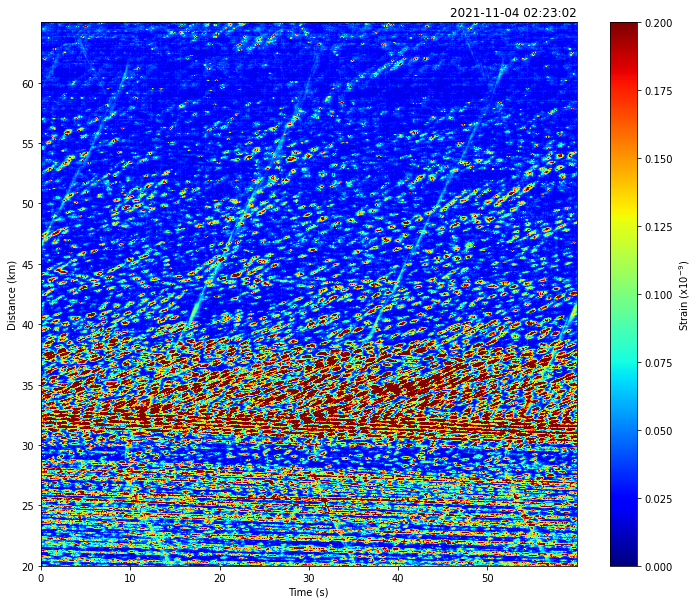

In [7]:
# band-pass filter
trf = sp.sosfiltfilt(sos_bpfilt, tr, axis=1)

# Plot
dw.plot.plot_tx(trf, time
                , dist, fileBeginTimeUTC)

In [ ]:
import matplotlib.pyplot as plt

nfft = 256
freq = np.fft.fftshift(np.fft.fftfreq(nfft, d=1 / fs))
fx = dw.dsp.get_fx(trf, nfft)

fig = plt.figure(figsize=(12, 10))
shw = plt.imshow(trf, extent=[freq[0], freq[-1], dist[0] * 1e-3, dist[-1] * 1e-3], aspect='auto',
                origin='lower', cmap='jet', vmin=0, vmax=0.02)

plt.xlim([0, 100])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Distance (km)')

# Colorbar
bar = plt.colorbar(shw, aspect=50)
bar.set_label('Strain (x$10^{-9}$)')

## Apply f-k and plot

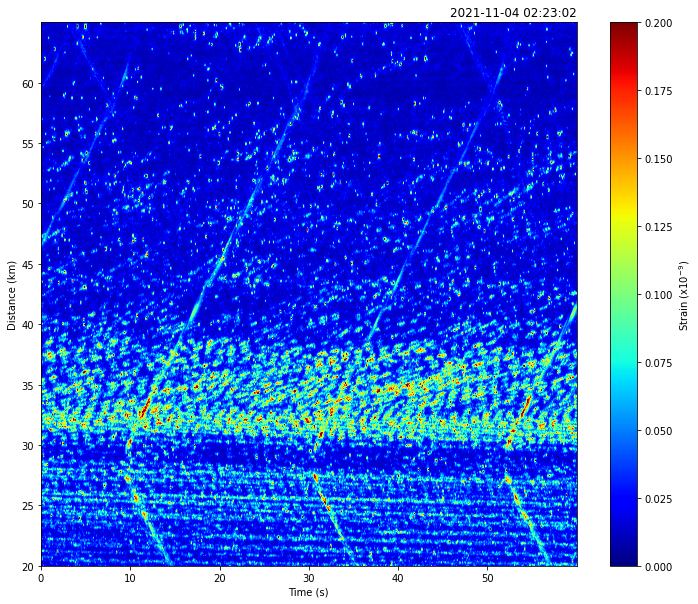

In [22]:
# FK filter
trf_fk = dw.dsp.fk_filtering(trf, selected_channels, dx, fs, c_min=1450, c_max=3600)

# Plot
dw.plot.plot_tx(trf_fk, time, dist, fileBeginTimeUTC)

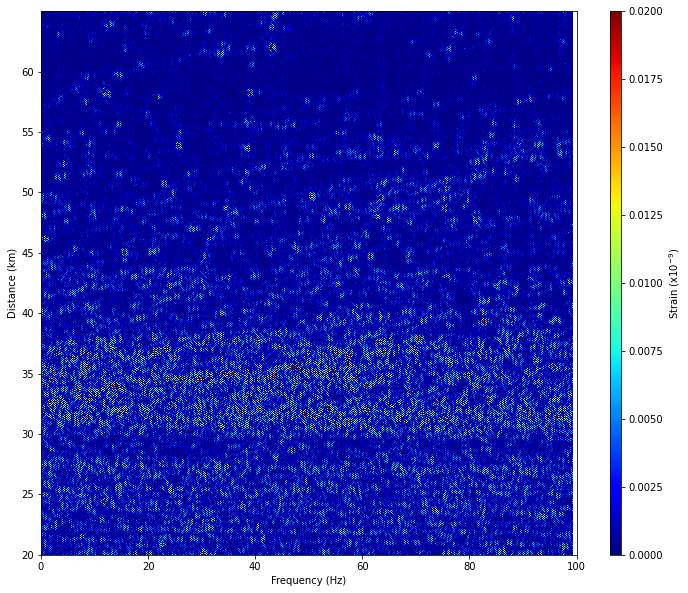